# Прогнозирование заказов такси

Агрегатор такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Для этого:

 - Загрузим данные и выполним их ресемплирование по одному часу;
 - Проведем анализ;
 - Обучим разные модели с различными гиперпараметрами и сделаем тестовую выборку размером 10% от исходных данных;
 - Проверим данные на тестовой выборке и сделаем выводы.

## Подготовка

In [1]:
#импортируем необходимые библиотеки

import time

import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

In [2]:
IS_LOCAL = True #открываем файл локально

if IS_LOCAL:
    data = pd.read_csv(r"C:\Users\yana\Desktop\taxi.csv")
else:
    data = pd.read_csv("/datasets/taxi.csv")

In [3]:
def prepare(df): #фунция предобработки данных
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [4]:
prepare(data)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

datetime      0
num_orders    0
dtype: int64

0

## Анализ

In [5]:
data.describe() #смотрим распределение заказов в датафрйме

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
def plot_f(data, column_): #функция для построения графиков размаха для данных
    data.boxplot(column=[column_])
    plt.show()

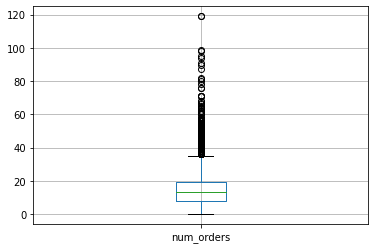

In [7]:
plot_f(data, 'num_orders')

Проведем ресеплемирование по одному часу

<AxesSubplot:title={'center':'Временной график после ресэмпленирования'}, xlabel='Дата', ylabel='Количество заказов'>

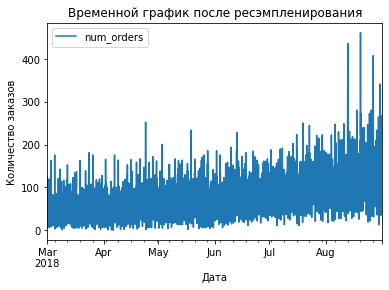

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime').sort_index()

data = data.resample('1H').sum()
data.plot(title = 'Временной график после ресэмпленирования', xlabel = 'Дата', ylabel = 'Количество заказов', ax=plt.gca())

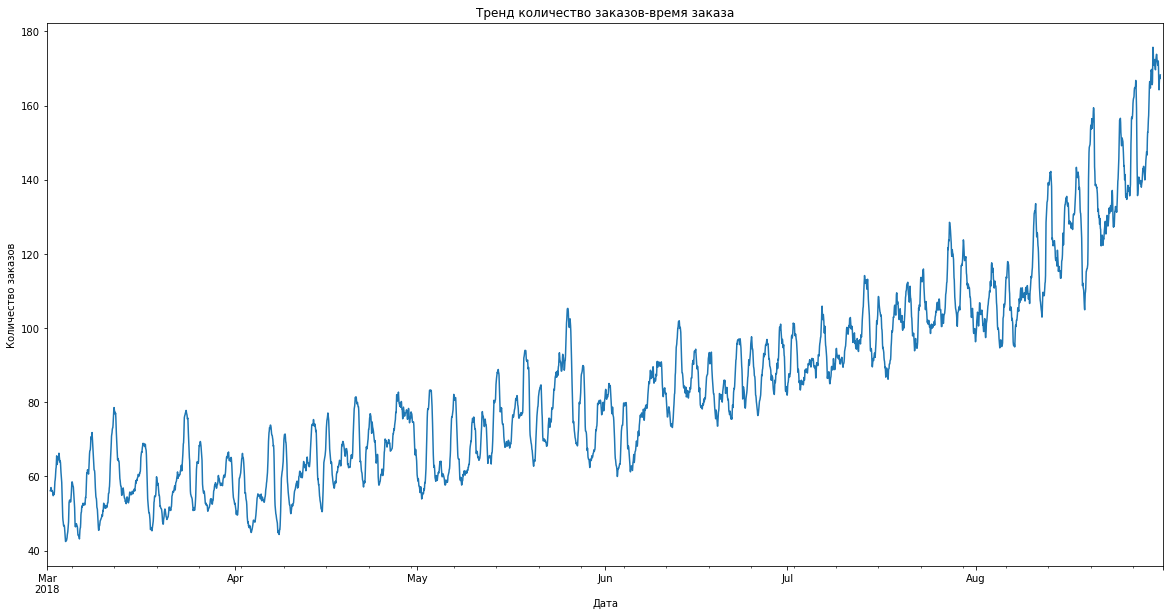

In [9]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize=(20,10), 
                      title = 'Тренд количество заказов-время заказа', 
                      xlabel = 'Дата', 
                      ylabel = 'Количество заказов');

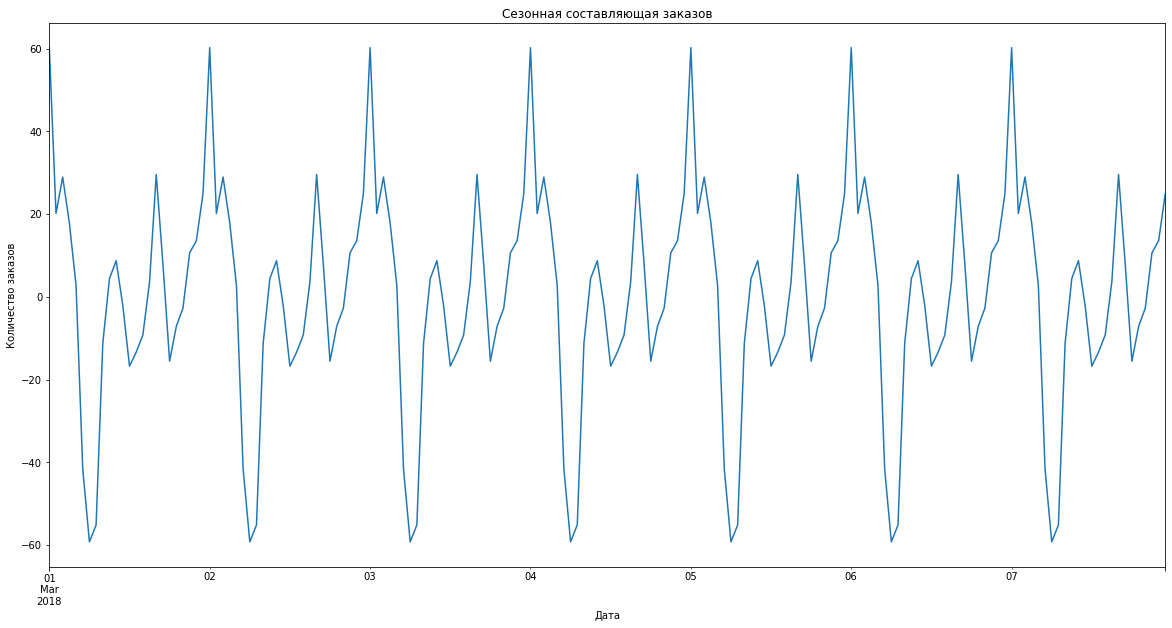

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(20,10), 
                                                    title='Сезонная составляющая заказов', 
                                                    xlabel = 'Дата', 
                                                    ylabel = 'Количество заказов');

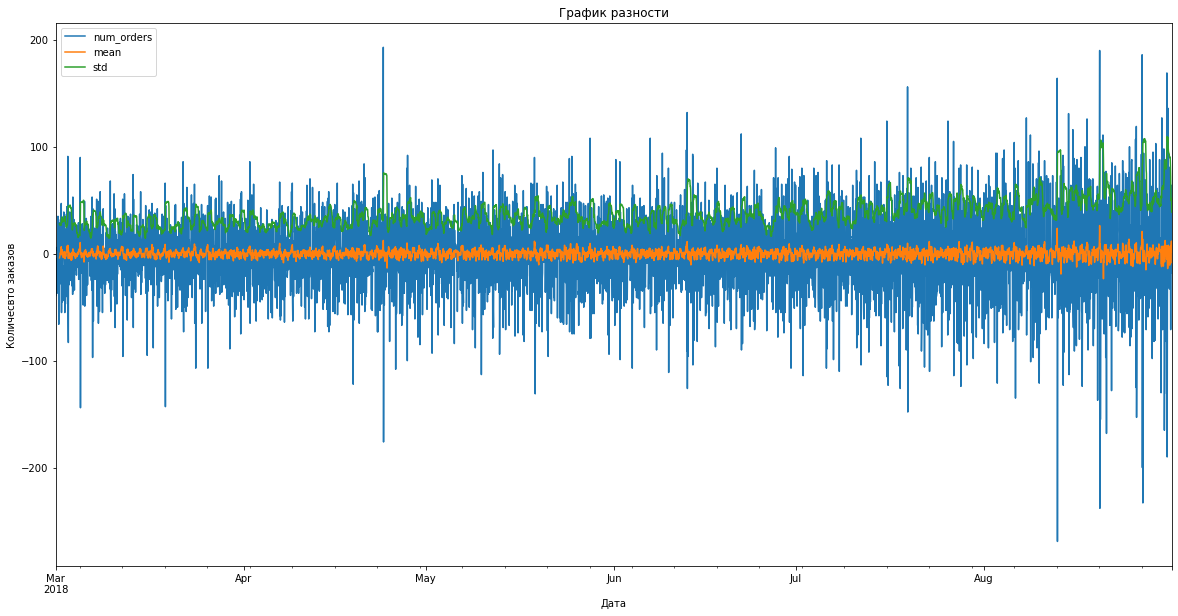

In [11]:
diffrenses = data.copy()
diffrenses = diffrenses-diffrenses.shift()
diffrenses['mean'] = diffrenses['num_orders'].rolling(15).mean()
diffrenses['std'] = diffrenses['num_orders'].rolling(15).std()
diffrenses.plot(figsize=(20,10), title = 'График разности', xlabel = 'Дата', ylabel = 'Количесвто заказов');

Провели ресемпленирование по часам. По диаграмме распределения и графику распределения видно,что медианное количество между 10 и 20, имеются выбросы до 120. Постепенно равномерно к теплому сезону количество заказов растет и летом оно пиковое. Применив функцию "seasonal_decompose" посмотрим на данные точнее. Тренд в данных восходящий. Если посмотреть летом за промежуток времени равному неделе, то мы увидим, что данные цикличные и пик приходится на вечер, а утром наоборот заказов меньше всего. По графику разности, который нам помогает привести данные к более стационарному виду, мы видим, что к летнему периоду хоть тренд и заметно растет, стандартное отклонение увеличевается постепенно и равномерно.

## Обучение

### Подготовим выборки

In [12]:
data_n = data.copy(deep=True)

In [13]:
def make_features(data, max_lag, rolling_sum_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_sum'] = data['num_orders'].shift().rolling(rolling_sum_size).mean()
    
    return data

In [14]:
make_features(data_n, 20, 24)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,168.041667


In [15]:
data_n = data_n.dropna()

In [16]:
train, test = train_test_split(data_n, shuffle=False, test_size=0.1)

train_x = train.drop(['num_orders'], axis=1)
train_y = train['num_orders']

test_x = test.drop(['num_orders'], axis=1)
test_y = test['num_orders']

In [17]:
def modeling(model, parametrs): 
    
    #Функция для поиска наилучших гиперпараметров модели на основе кроссвалидации, 
    #которая возвращает обученную модель уже с наилучшими параметрами
    
    tscv = TimeSeriesSplit(n_splits=6, test_size=60)
    grid = GridSearchCV(model, param_grid=parametrs, cv=tscv, scoring='neg_root_mean_squared_error', verbose=4, n_jobs=-1)
    grid.fit(train_x, train_y)
    
    print(f'RMSE во время кросс валидации = {-grid.best_score_}')
    
    print('Параметры наилучшей модели')
    
    print(grid.best_params_)
    
    return grid.best_estimator_.fit(train_x, train_y)

### LinearRegression

In [18]:
model_l = LinearRegression()
parametrs = {'fit_intercept':[True,False]}

model_l = modeling(model_l, parametrs)

Fitting 6 folds for each of 2 candidates, totalling 12 fits
RMSE во время кросс валидации = 35.70901777805616
Параметры наилучшей модели
{'fit_intercept': False}


### LGBMRegressor

In [19]:
model_lgbmr = LGBMRegressor(random_state=4782)
parametrs = {'n_estimators':range(300, 800, 50), 
             'boosting_type':['gbdt', 'dart', 'goss']}

model_lgbmr = modeling(model_lgbmr, parametrs)

Fitting 6 folds for each of 30 candidates, totalling 180 fits
RMSE во время кросс валидации = 29.9652727962624
Параметры наилучшей модели
{'boosting_type': 'gbdt', 'n_estimators': 300}


### RandomForest

In [20]:
model_rf = RandomForestRegressor(random_state=4782)
parametrs = {'n_estimators':range(200, 351, 50), 
             'min_samples_split':[2, 3], 
             'min_samples_leaf':[1, 2]}

model_rf = modeling(model_rf, parametrs)

Fitting 6 folds for each of 16 candidates, totalling 96 fits
RMSE во время кросс валидации = 29.674972790914353
Параметры наилучшей модели
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## Тестирование

### Тестируем наилучшую модель - RandomForestRegressor

In [21]:
predict_y = model_rf.predict(test_x)
rmse_rf = mean_squared_error(test_y, predict_y) ** 0.5
print(rmse_rf)

43.46241453627758


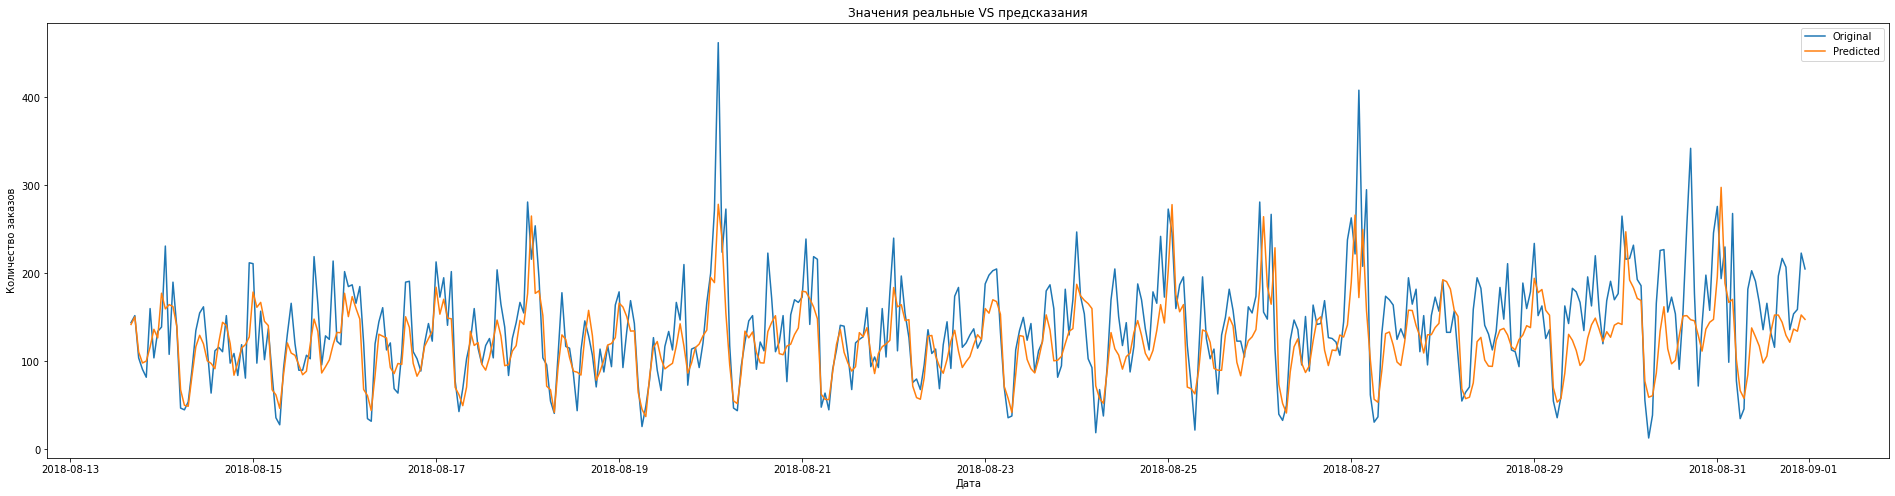

In [24]:
plt.figure(figsize=(33, 8))

sns.lineplot(x = test_y.index, y = test_y, label = 'Original')
sns.lineplot(x = test_y.index, y = predict_y, label = 'Predicted')
plt.legend()
plt.title('Значения реальные VS предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

## Вывод:

По результатам наших моделей можем сказать, что наилучшей оказалась RandomForestRegressor и ее значения RMSE на тестовой выборке 43, то есть соотвестсвует требованиям задачи "Значение RMSE на тестовой выборке не больше 48".

В процессе выполнения проекта были проанализированы данные, в том числе с помощью библиотеки "statsmodels". Были обучены несколько моделей и была выбрана наилучшая и проверена на тестовой выборке. В конце для репрезентативности ее предсказательная способность отражена на графике.